In [1]:
import numpy as np, time, random, warnings, functools, os, sys
from gammabayes.utils import update_with_defaults
from tqdm import tqdm
from scipy.special import logsumexp
from scipy.interpolate import interp1d

print(time.strftime("%H:%M:%S"))

random.seed(0)

19:05:32


In [2]:
from gammabayes.likelihoods.irfs import IRF_LogLikelihood
from gammabayes.utils.config_utils import (
    read_config_file, 
    create_true_axes_from_config, 
    create_recon_axes_from_config, 
)
from gammabayes.utils import dynamic_import

from matplotlib import pyplot as plt

config_file_path = 'ConfigFiles/Reweighting_config.yaml'
config_dict = read_config_file(config_file_path)

source_hyperparameter_input = config_dict['parameter_specifications']
mixture_bounds               = [config_dict['mixture_fraction_specifications'][mixture]['bounds'] for mixture in config_dict['mixture_fraction_specifications']]

NumEvents                   = config_dict['Nevents']
truemass                    = config_dict['dark_matter_mass']
signal_fraction             = config_dict['signal_fraction']
ccr_of_bkg_fraction         = config_dict['ccr_of_bkg_fraction']
diffuse_of_astro_fraction   = config_dict['diffuse_of_astro_fraction']

nsig = int(round(signal_fraction*NumEvents))
nccr = int(round((1-signal_fraction)*ccr_of_bkg_fraction*NumEvents))
ndiffuse = int(round((1-signal_fraction)*(1-ccr_of_bkg_fraction)*diffuse_of_astro_fraction*NumEvents))
nlocal = int(round((1-signal_fraction)*(1-ccr_of_bkg_fraction)*(1-diffuse_of_astro_fraction)*NumEvents))


if nsig+nccr+ndiffuse+nlocal!=NumEvents:
    print(nsig, nccr, ndiffuse, nlocal)

assert nsig+nccr+ndiffuse+nlocal==NumEvents

file path: standard_local_config_reweight.yaml


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
energy_true_axis,  longitudeaxistrue, latitudeaxistrue       = create_true_axes_from_config(config_dict)
energy_recon_axis, longitudeaxis,     latitudeaxis           = create_recon_axes_from_config(config_dict)


irf_loglike = IRF_LogLikelihood(axes   =   [energy_recon_axis,    longitudeaxis,     latitudeaxis], 
                                dependent_axes =   [energy_true_axis,     longitudeaxistrue, latitudeaxistrue],)

# log_psf_normalisations, log_edisp_normalisations = irf_loglike.create_log_norm_matrices()
# irf_norm_matrix = log_psf_normalisations + log_edisp_normalisations

0.2 90.0 100 0.2 -3.0 3.0 -3.0 3.0
0.2 90.0 50 0.4 -3.0 3.0 -3.0 3.0

Path to irf fits file: /Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/../package_data/irf_fits_files/prod5/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz

Number of input dimensions 3


In [4]:
# np.save('irf_norm_matrix.npy', irf_norm_matrix)
irf_norm_matrix = np.load('irf_norm_matrix.npy')
irf_norm_matrix.shape

(266, 31, 31)

In [5]:
irf_norm_matrix.shape

(266, 31, 31)

In [6]:
from gammabayes.likelihoods import DiscreteLogLikelihood
from gammabayes.priors.astro_sources import (
    construct_hess_source_map, 
    construct_fermi_gaggero_matrix, 
    construct_hess_source_map_interpolation, 
    construct_log_fermi_gaggero_bkg,
)
from gammabayes.dark_matter import CombineDMComps
from gammabayes.dark_matter.density_profiles import Einasto_Profile

from gammabayes.priors import DiscreteLogPrior, log_bkg_CCR_dist, TwoCompPrior
dark_matter_spectral_class = dynamic_import('gammabayes.dark_matter.spectral_models', config_dict['dark_matter_spectral_model'])

In [7]:
DM_prior = TwoCompPrior(name='Z2 Scalar Singlet dark matter',
                        spectral_class = dark_matter_spectral_class, 
                        spatial_class = Einasto_Profile,
                        irf_loglike=irf_loglike, spectral_class_kwds={'ratios':True},
                        axes=(energy_true_axis, 
                              longitudeaxistrue, 
                              latitudeaxistrue,), 
                        axes_names=['energy', 'lon', 'lat'],
                        default_spectral_parameters={'mass':config_dict['dark_matter_mass']}, )



In [8]:
ccr_bkg_prior = DiscreteLogPrior(logfunction=log_bkg_CCR_dist, name='CCR Mis-identification Background',
                               axes=(   energy_true_axis, 
                                        longitudeaxistrue, 
                                        latitudeaxistrue,), 
                                    axes_names=['energy', 'lon', 'lat'], )


from gammabayes.priors.astro_sources import FermiGaggeroDiffusePrior, HESSCatalogueSources_Prior
diffuse_astro_bkg_prior = FermiGaggeroDiffusePrior(energy_axis=energy_true_axis, longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue, irf=irf_loglike)
point_astro_bkg_prior = HESSCatalogueSources_Prior(energy_axis=energy_true_axis, longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue, irf=irf_loglike)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:583: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')


In [9]:
def proposal_func(energy, longitude, latitude, spectral_parameters={}, spatial_parameters={}):
    return np.log(energy**(-1))

proposal_prior = DiscreteLogPrior(logfunction          =   proposal_func,
                                       name                 =   'Proposal',
                                       axes                 =   (energy_true_axis, 
                                                                 longitudeaxistrue, 
                                                                 latitudeaxistrue,), 
                                       axes_names           =    ['energy', 'lon', 'lat'], )

# Simulations

In [10]:
sig_event_data  = DM_prior.sample(nsig)
ccr_event_data  = ccr_bkg_prior.sample(nccr)
diffuse_event_data  = diffuse_astro_bkg_prior.sample(ndiffuse)
point_event_data  = point_astro_bkg_prior.sample(nlocal)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/core/data_class.py:123: UserWarning: No energy, longitude or latitude values given. Assigning empty lists.
  warnings.warn("No energy, longitude or latitude values given. Assigning empty lists.")


In [11]:
# for source_idx, event_data in enumerate([ccr_event_data, diffuse_event_data, point_event_data, sig_event_data]):
#     print(np.unique(event_data._source_ids))
#     fig, ax = event_data.peek()
#     if source_idx==3:
#         direct_values = np.exp(DM_prior(energy_true_axis, energy_true_axis*0, energy_true_axis*0, spectral_parameters={'mass':energy_true_axis*0+1.0})+np.log(energy_true_axis))
#         # ax[0].plot(energy_true_axis, direct_values/np.max(direct_values)*4000, alpha=0.5)

    



In [12]:
from gammabayes import EventData

true_events = sig_event_data+ccr_event_data+diffuse_event_data+point_event_data


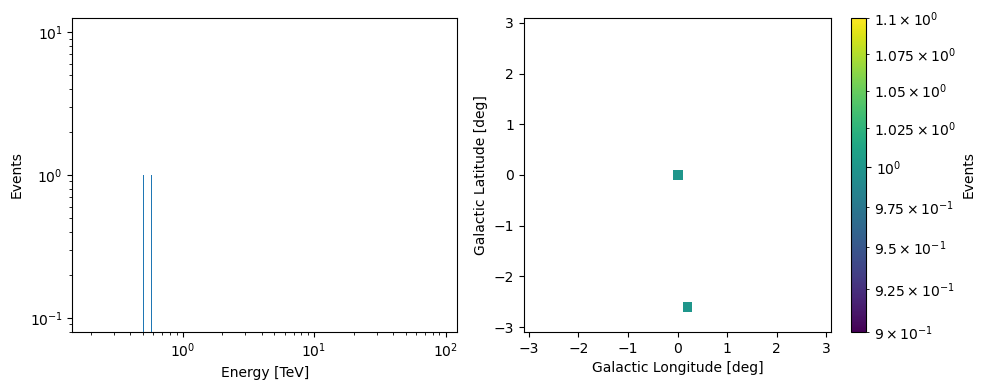

In [13]:
true_events.peek()
plt.show()

In [14]:
measured_event_data = irf_loglike.sample(true_events)

In [15]:
# measured_event_data.save("measured_data")

In [16]:
# measured_event_data.load_from_hdf5("measured_data.h5")

# Nuisance Parameter Marg

In [17]:
from gammabayes.hyper_inference import ScanReweighting as reweighting_class

In [18]:
reweighting_class_instance = reweighting_class(
    measured_events=measured_event_data.data, 
    log_likelihood=irf_loglike, 
    log_proposal_prior=proposal_prior, 
    log_target_priors=[DM_prior, ccr_bkg_prior, diffuse_astro_bkg_prior, point_astro_bkg_prior], 
    nuisance_axes=DM_prior.axes, 
    marginalisation_bounds=[['log10', 0.36], ['linear', 0.44], ['linear', 0.44]],
    prior_parameter_specifications={}, reweight_batch_size=100
)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/hyper_inference/utils.py:50: UserWarning: 
You have specifed 4 less hyperparameter axes than priors. 
Assigning empty hyperparameter axes for remaining priors.
  warnings.warn(f"""


In [19]:
nuisance_log_marg_results=  reweighting_class_instance.batch_process_proposal_sampling(tqdm(measured_event_data))


100%|██████████| 2/2 [01:08<00:00, 34.25s/it]


In [20]:
from gammabayes import ParameterSet

log_marg_results = reweighting_class_instance.scan_reweight( 
                      log_evidence_values=nuisance_log_marg_results[0], 
                      nested_sampling_results_samples=nuisance_log_marg_results[1],  
                      prior_parameter_specifications=[ParameterSet(config_dict['parameter_specifications'])])

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/hyper_inference/utils.py:50: UserWarning: 
You have specifed 3 less hyperparameter axes than priors. 
Assigning empty hyperparameter axes for remaining priors.
  warnings.warn(f"""
  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:51<00:00, 12.83s/it]


In [21]:
sigresults = log_marg_results[0]

In [22]:
sigresults.shape

(2, 7, 7)

In [23]:
single_comp_results = np.sum(sigresults[:nsig], axis=0)


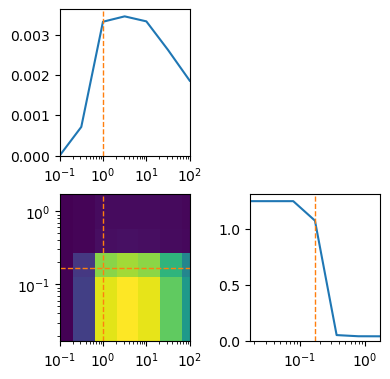

In [24]:
from gammabayes.utils.plotting import logdensity_matrix_plot
from scipy import special

prior_param_set = ParameterSet(config_dict['parameter_specifications'])
prior_param_set_axes = [np.asarray(axis) for axis in prior_param_set.axes]

# try:
fig, ax = logdensity_matrix_plot(log_dist_matrix=single_comp_results, 
                    axes=prior_param_set_axes,
                            plot_density=1, contours2d=0, sigmalines_1d=0,
                            truevals=[1.0 ,0.17],
                            single_dim_yscales='linear', figsize=(4,4))
ax[0,0].set_xscale('log')

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[1,1].set_xscale('log')
# except:
#     plt.figure(figsize=(8,4))
#     plt.plot(*prior_param_set.axes, np.exp(single_comp_results))
#     plt.xscale('log')
#     plt.show()



In [25]:
mixture_parameter_set = ParameterSet(config_dict['mixture_fraction_specifications'])
prior_parameter_sets = ParameterSet(config_dict['parameter_specifications'])


In [26]:
reweighting_class_instance.select_scan_output_posterior_exploration_class(
    log_nuisance_marg_results=log_marg_results,
    mixture_parameter_specifications=mixture_parameter_set,
    prior_parameter_specifications = [ParameterSet(config_dict['parameter_specifications']),],
    mixture_fraction_exploration_type='scan'
)

reweighting_class_instance.init_posterior_exploration(
    num_in_batches = 500
    )

In [27]:
reweighting_class_instance.run_posterior_exploration()

array([[[[[[[[ -61.75748868]]],


           [[[ -61.75748868]]],


           [[[ -61.75748868]]],


           ...,


           [[[ -61.75748868]]],


           [[[ -61.75748868]]],


           [[[ -61.75748868]]]],



          [[[[ -61.75748868]]],


           [[[ -61.75748868]]],


           [[[ -61.75748868]]],


           ...,


           [[[ -61.75748868]]],


           [[[ -61.75748868]]],


           [[[ -61.75748868]]]],



          [[[[ -61.75748868]]],


           [[[ -61.75748868]]],


           [[[ -61.75748868]]],


           ...,


           [[[ -61.75748868]]],


           [[[ -61.75748868]]],


           [[[ -61.75748868]]]],



          ...,



          [[[[ -61.75748868]]],


           [[[ -61.75748868]]],


           [[[ -61.75748868]]],


           ...,


           [[[ -61.75748868]]],


           [[[ -61.75748868]]],


           [[[ -61.75748868]]]],



          [[[[ -61.75748868]]],


           [[[ -61.75748868]]],


           [[[ -61

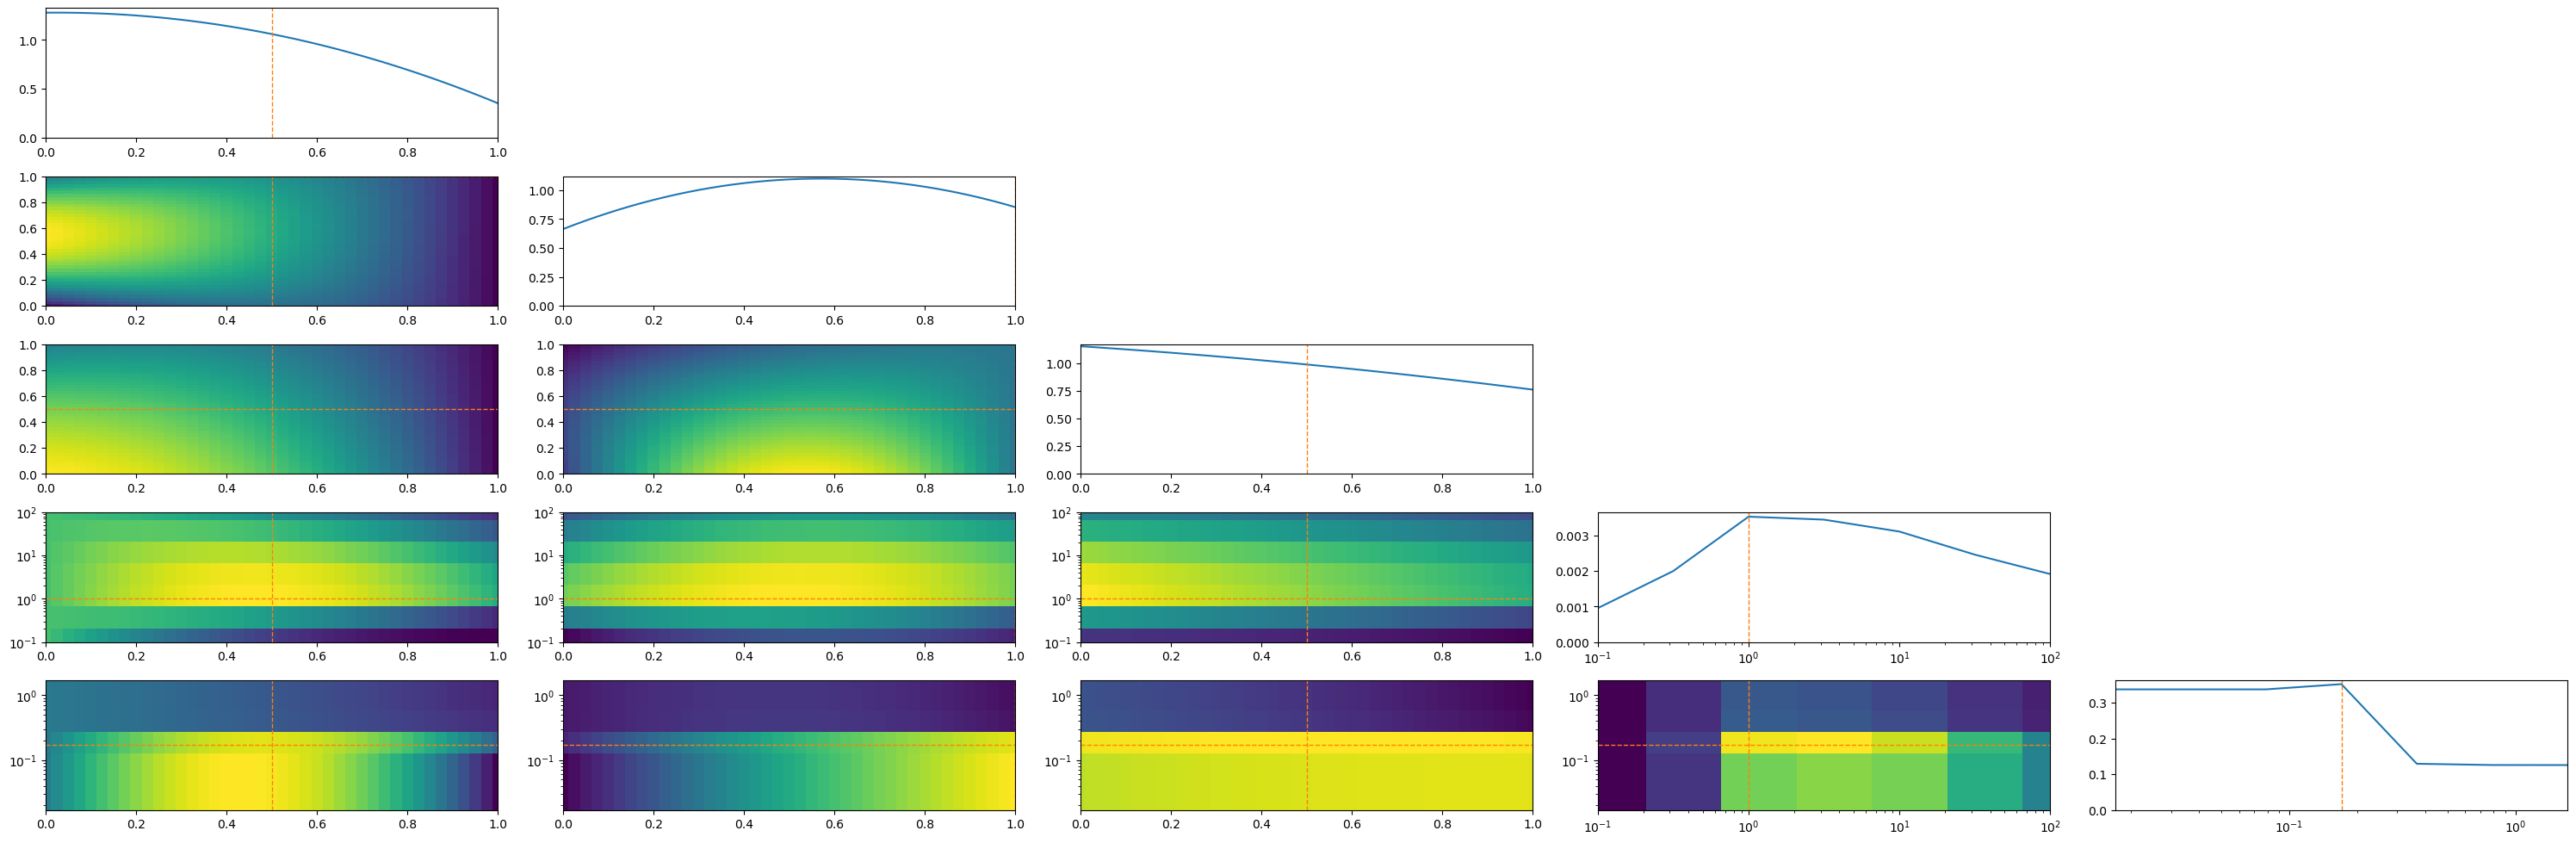

In [28]:
prior_param_set = ParameterSet(config_dict['parameter_specifications'])
mixture_param_set = ParameterSet(config_dict['mixture_fraction_specifications'])
from gammabayes.utils.plotting import logdensity_matrix_plot
from scipy import special

log_hyperparameter_likelihood = np.squeeze(reweighting_class_instance.posterior_exploration_results)
log_hyperparameter_likelihood = log_hyperparameter_likelihood - special.logsumexp(log_hyperparameter_likelihood)

fig, ax = logdensity_matrix_plot(log_dist_matrix=log_hyperparameter_likelihood, 
                       axes=[*mixture_param_set.axes, 
                             *prior_param_set_axes],
                             plot_density=1, contours2d=0, sigmalines_1d=0,
                             truevals=[0.5, 1, 0.5, 1.0, 0.17],
                             single_dim_yscales='linear', figsize=(30,10))


ax[3,0].set_yscale('log')
ax[3,1].set_yscale('log')
ax[3,2].set_yscale('log')

ax[3,3].set_xscale('log')

ax[4,0].set_yscale('log')
ax[4,1].set_yscale('log')
ax[4,2].set_yscale('log')
ax[4,3].set_yscale('log')
ax[4,3].set_xscale('log')

ax[4,4].set_xscale('log')

In [30]:
reweighting_class_instance.save('reweight_save_test.h5')

In [31]:
loaded_reweighting_class_instance = reweighting_class.load('reweight_save_test.h5')

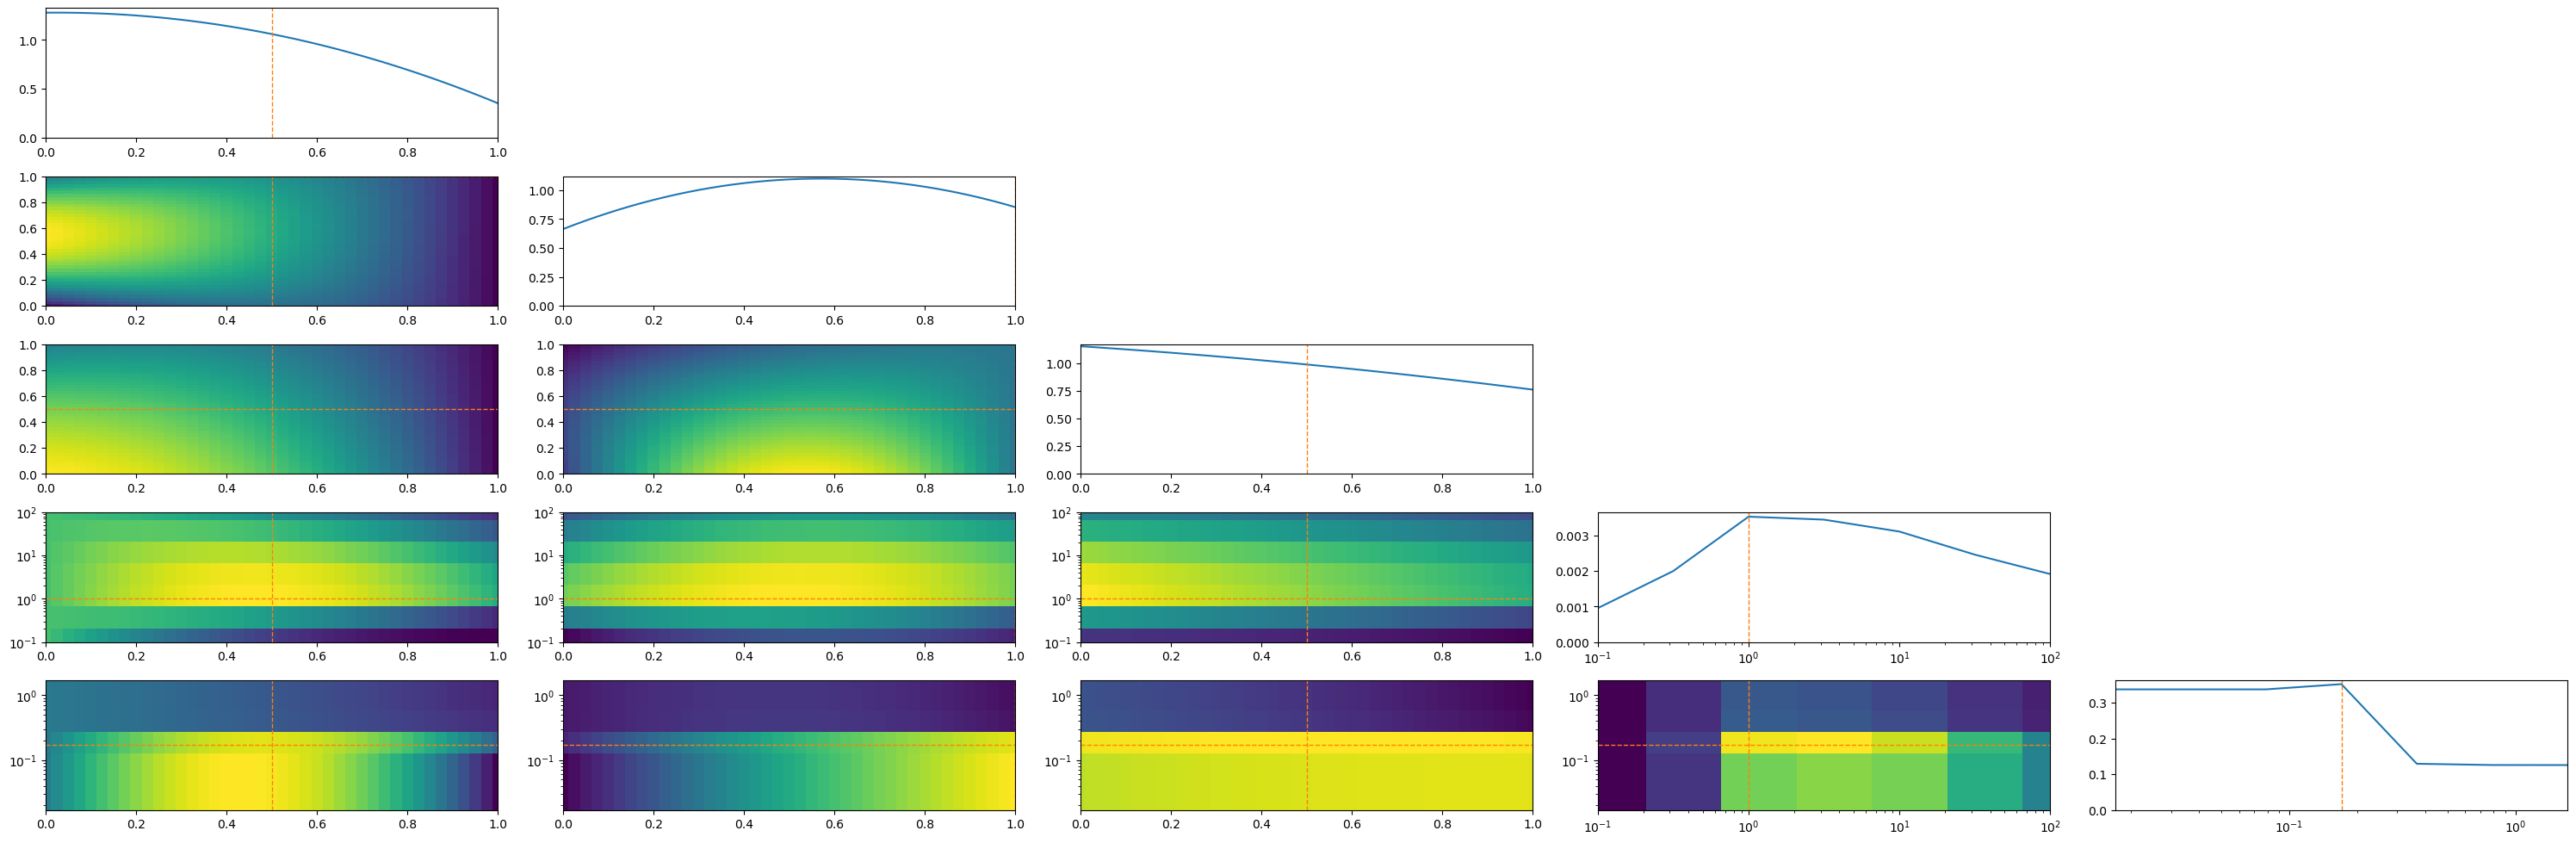

In [33]:
prior_param_set = ParameterSet(config_dict['parameter_specifications'])
mixture_param_set = ParameterSet(config_dict['mixture_fraction_specifications'])
from gammabayes.utils.plotting import logdensity_matrix_plot
from scipy import special

log_hyperparameter_likelihood = np.squeeze(loaded_reweighting_class_instance.log_hyperparameter_likelihood)
log_hyperparameter_likelihood = log_hyperparameter_likelihood - special.logsumexp(log_hyperparameter_likelihood)

fig, ax = logdensity_matrix_plot(log_dist_matrix=log_hyperparameter_likelihood, 
                       axes=[*mixture_param_set.axes, 
                             *prior_param_set_axes],
                             plot_density=1, contours2d=0, sigmalines_1d=0,
                             truevals=[0.5, 1, 0.5, 1.0, 0.17],
                             single_dim_yscales='linear', figsize=(30,10))


ax[3,0].set_yscale('log')
ax[3,1].set_yscale('log')
ax[3,2].set_yscale('log')

ax[3,3].set_xscale('log')

ax[4,0].set_yscale('log')
ax[4,1].set_yscale('log')
ax[4,2].set_yscale('log')
ax[4,3].set_yscale('log')
ax[4,3].set_xscale('log')

ax[4,4].set_xscale('log')